In [21]:
# Create a virtual environment named 'env'
!python -m venv env

# Activate the virtual environment
# For Windows
!.\env\Scripts\activate

In [22]:
# Install packages from requirements.txt
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
You should consider upgrading via the 'C:\Users\suyog\OneDrive\Desktop\Projects\DA_AI_Agent\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [23]:
# List installed packages to verify installation
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.1.0
annotated-types              0.7.0
anyio                        4.8.0
asttokens                    3.0.0
astunparse                   1.6.3
bleach                       6.2.0
cachetools                   5.5.1
certifi                      2025.1.31
charset-normalizer           3.4.1
click                        8.1.8
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.3.1
cycler                       0.12.1
debugpy                      1.8.12
decorator                    5.1.1
distro                       1.9.0
docstring_parser             0.16
exceptiongroup               1.2.2
executing                    2.2.0
Faker                        37.0.0
fastapi                      0.115.8
filelock                     3.17.0
flatbuffers                  25.2.10
fonttools                    4.56.0
fsspec                       2025.

You should consider upgrading via the 'C:\Users\suyog\OneDrive\Desktop\Projects\DA_AI_Agent\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [24]:
import torch
from dotenv import load_dotenv
import os
import pandas as pd
import re
from kaggle.api.kaggle_api_extended import KaggleApi
from phi.agent import Agent
from phi.model.groq import Groq
import pandasql as psql 

# Load environment variables
load_dotenv()

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


PyTorch Version: 2.5.1+cu121
CUDA Available: True
CUDA Version: 12.1
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [25]:
# verify GPU perfrmance
import torch
x = torch.rand(10000, 10000).cuda()
print(x.device)

cuda:0


In [26]:
import pandas as pd
import random
from faker import Faker
from datetime import datetime, timedelta

# Initialize Faker for random data generation
fake = Faker()

# Function to generate random dates within a range of years (2020 to 2025)
def generate_random_date(start_year=2020, end_year=2025):
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year, 12, 31)
    random_date = start_date + timedelta(seconds=random.randint(0, int((end_date - start_date).total_seconds())))
    return random_date

# Generate sample data for Customers
customers_data = []
for i in range(1, 100001):  # 100k customers
    customers_data.append({
        "customer_id": i,
        "name": fake.name(),
        "email": fake.email(),
        "address": fake.address()
    })
customers_df = pd.DataFrame(customers_data)

# Generate sample data for Products
products_data = []
product_names = ['Laptop', 'Smartphone', 'Headphones', 'Tablet', 'Monitor', 'Keyboard', 'Mouse', 'Camera', 'Printer', 'Smartwatch']
for i in range(1, 21):  # 20 products
    products_data.append({
        "product_id": i,
        "name": random.choice(product_names),
        "price": round(random.uniform(50, 2000), 2),
        "stock_quantity": random.randint(1, 100)
    })
products_df = pd.DataFrame(products_data)

# Generate sample data for Orders with random dates between 2020 and 2025
orders_data = []
for i in range(1, 100001):  # 100k orders
    orders_data.append({
        "order_id": i,
        "customer_id": random.randint(1, 1000),
        "order_date": generate_random_date(),  # Random date between 2020 and 2025
        "total_price": round(random.uniform(100, 5000), 2)
    })
orders_df = pd.DataFrame(orders_data)

# Generate sample data for Order_Items (with random products and quantities)
order_items_data = []
for order_id in range(1, 100001):  # Matching 100k orders
    for _ in range(random.randint(1, 5)):  # Each order can have 1 to 5 items
        order_items_data.append({
            "order_item_id": len(order_items_data) + 1,
            "order_id": order_id,
            "product_id": random.randint(1, 20),
            "quantity": random.randint(1, 3),
            "unit_price": round(random.uniform(50, 2000), 2)
        })
order_items_df = pd.DataFrame(order_items_data)

# Register DataFrames as SQL tables
table_dict = {
    'Customers': customers_df,
    'Products': products_df,
    'Orders': orders_df,
    'Order_Items': order_items_df
}

# Function to execute the generated SQL query on DataFrames
def execute_sql_on_dataframe(query, table_dict):
    # Execute the SQL query using pandasql
    result_df = ps.sqldf(query, table_dict)
    return result_df

# Now you have DataFrames with random data, and the order_date will range from 2020 to 2025.


##### -------------------------- AI Agent1 for SQL query builder --------------------------

In [27]:
# Initialize AI SQL Agent
sql_agent = Agent(model=Groq(id="llama-3.3-70b-versatile"))

# Define the schema and relationships
table_schemas = {
    "Customers": ["customer_id", "name", "email", "address"],
    "Products": ["product_id", "name", "price", "stock_quantity"],
    "Orders": ["order_id", "customer_id", "order_date", "total_price"],
    "Order_Items": ["order_item_id", "order_id", "product_id", "quantity", "unit_price"]
}

# Define relationships based on schema
relationships = {
    "Customers": {
        "Orders": "customer_id"  # Customers can have many Orders (1:N)
    },
    "Orders": {
        "Order_Items": "order_id"  # Orders can have many Order_Items (1:N)
    },
    "Products": {
        "Order_Items": "product_id"  # Products can be part of many Order_Items (1:N)
    }
}

# Function to generate SQL query with JOINs based on user intent
def generate_sql_query(natural_language_query, table_schemas, relationships):
    # Format the schema and relationships for the AI model to understand
    schema_info = "\n".join([f"Table `{name}`: Columns -> {', '.join(columns)}" for name, columns in table_schemas.items()])
    relationships_info = "\n".join([f"Table `{parent}` has a relationship with `{child}` on the column `{col}`"
                                   for parent, related_tables in relationships.items() for child, col in related_tables.items()])

    # Construct the prompt with schema and relationships information
    prompt = f"""
    You are an expert SQL assistant. Convert the following natural language request into a valid SQL query. 
    The database contains multiple tables with relationships inferred from common columns.

    Information about the dataset:
    {schema_info}

    Relationships between tables:
    {relationships_info}

    The user request is: "{natural_language_query}"

    Generate an optimized SQL query with proper JOIN operations if needed.
    Ensure that the query is simple, efficient, and produces the correct result based on the provided information.
    """

    # Query generation from AI agent
    response = sql_agent.run(prompt)
    return response.content  # Extract generated SQL


In [39]:
import sqlparse  # Optional for formatting the query

# Prompt user for input (natural language query)
print("Welcome to the SQL Query Generator!")
print("Please enter your natural language query (e.g., 'Calculate total sales for this month' or 'Get sales by product for the last quarter'): ")

# Get user input (natural language query)
user_input = input().strip()  # Sanitize input by removing extra spaces

# Generate the SQL query based on the user's input
try:
    sql_query = generate_sql_query(user_input, table_schemas, relationships)

    # Check if the query is valid
    if not sql_query.strip():
        raise ValueError("Generated SQL query is empty or invalid.")
    
    # Format the query for readability
    sql_query = sqlparse.format(sql_query, reindent=True, keyword_case='upper')

except Exception as e:
    print(f"Error generating SQL query: {e}")
    sql_query = None

# Output the generated SQL query (if valid)
if sql_query:
    print("\nGenerated SQL Query:")
    print(sql_query)
else:
    print("Failed to generate a valid SQL query. Please try again.")


Welcome to the SQL Query Generator!
Please enter your natural language query (e.g., 'Calculate total sales for this month' or 'Get sales by product for the last quarter'): 

Generated SQL Query:
TO generate a daily sales
AND volume report
FOR ALL products,
        you would need TO
JOIN the `Orders`,
     `Order_Items`,
AND `Products` tables. The query should calculate the total sales (total_price * quantity)
AND the quantity sold
FOR EACH product ON EACH day. Here's a SQL query that accomplishes this:

```sql
SELECT 
    oi.product_id,
    p.name AS product_name,
    o.order_date AS sales_date,
    SUM(oi.quantity) AS daily_volume,
    SUM(oi.unit_price * oi.quantity) AS daily_sales
FROM 
    Orders o
JOIN 
    Order_Items oi ON o.order_id = oi.order_id
JOIN 
    Products p ON oi.product_id = p.product_id
GROUP BY 
    oi.product_id, p.name, o.order_date
ORDER BY 
    oi.product_id, o.order_date;
```

This query:

1. Joins the `Orders`, `Order_Items`, and `Products` tables based on th

In [40]:
import re

# Try to extract the SQL query part using regex
match = re.search(r"(?s)```sql(.*?)```", sql_query)

if match:
    # Clean and extract the SQL query if found
    sql_query_cleaned = match.group(1).strip()
    print("\nGenerated CLEANED SQL Query:")
    print(sql_query_cleaned)
else:
    print("Error: No valid SQL query found in the provided text.")



Generated CLEANED SQL Query:
SELECT 
    oi.product_id,
    p.name AS product_name,
    o.order_date AS sales_date,
    SUM(oi.quantity) AS daily_volume,
    SUM(oi.unit_price * oi.quantity) AS daily_sales
FROM 
    Orders o
JOIN 
    Order_Items oi ON o.order_id = oi.order_id
JOIN 
    Products p ON oi.product_id = p.product_id
GROUP BY 
    oi.product_id, p.name, o.order_date
ORDER BY 
    oi.product_id, o.order_date;


In [41]:
# Ensure the query is valid (e.g., not empty or invalid syntax)
if sql_query_cleaned.strip() == "":
    print("Error: The generated SQL query is empty or invalid.")
else:
    print(f"Generated SQL Query: {sql_query_cleaned}")  # Print the query for debugging

    # Modify the query to use strftime for SQLite
    sql_query_cleaned = sql_query_cleaned.replace("DATE_TRUNC('month', o.order_date)", "strftime('%Y-%m', o.order_date)")

    try:
        # Execute the SQL query on the registered DataFrames
        output_df = execute_sql_on_dataframe(sql_query_cleaned, table_dict)
        
        # Display the resulting DataFrame (final output table)
        print("\nGenerated Output DataFrame:")
        
        # If the output DataFrame is too large, limit the rows displayed
        print(output_df.head())  # Show top 5 rows of the output by default
    except Exception as e:
        # Handle any errors that occur during SQL query execution
        print(f"Error executing the SQL query: {e}")


Generated SQL Query: SELECT 
    oi.product_id,
    p.name AS product_name,
    o.order_date AS sales_date,
    SUM(oi.quantity) AS daily_volume,
    SUM(oi.unit_price * oi.quantity) AS daily_sales
FROM 
    Orders o
JOIN 
    Order_Items oi ON o.order_id = oi.order_id
JOIN 
    Products p ON oi.product_id = p.product_id
GROUP BY 
    oi.product_id, p.name, o.order_date
ORDER BY 
    oi.product_id, o.order_date;

Generated Output DataFrame:
   product_id product_name                  sales_date  daily_volume  \
0           1        Mouse  2020-01-01 04:08:35.000000             1   
1           1        Mouse  2020-01-01 11:01:12.000000             3   
2           1        Mouse  2020-01-01 12:44:39.000000             3   
3           1        Mouse  2020-01-01 17:50:21.000000             1   
4           1        Mouse  2020-01-01 20:06:20.000000             1   

   daily_sales  
0       134.89  
1      4888.08  
2      3675.03  
3      1540.63  
4       122.39  


##### -------------------------- AI Agent2  for Insight Generation --------------------------

In [46]:
# Function to dynamically generate helpful business questions based on the dataset schema
def generate_dynamic_business_questions(table_schemas):
    questions = []
    
    # Sales-related questions
    questions.append("What are the total sales for each product?")
    questions.append("Which product has the highest sales volume?")
    questions.append("What is the total revenue generated by each product?")
    questions.append("What is the average order value?")
    
    # Customer insights
    questions.append("Which customers have spent the most on their orders?")
    questions.append("Which customers have made the highest number of orders?")
    questions.append("What is the total amount spent by each customer?")
    
    # Product insights
    questions.append("Which products have the highest stock quantity?")
    questions.append("Which products have the lowest stock quantity?")
    
    # Time/Trend-based questions
    questions.append("How have sales trended over time?")
    questions.append("Which months have seen the highest sales?")
    
    return questions

# AI-based insight agent to generate insights for dynamic business questions using Agent with llama-3.3-70b-versatile
def insight_agent(df, questions, model="llama-3.3-70b-versatile"):
    insights = {}
    
    # Initialize the Agent with the specified model
    ai_agent = Agent(model=Groq(id=model))
    
    for question in questions:
        # Prepare the prompt for the model, providing a compact dataset preview (first 10 rows)
        preview_data = output_df
        
        prompt = f"""
        You are a business data analyst. Below is a preview of the dataset and a business question. Provide clear, actionable business insights in response.

        Dataset Preview:
        {preview_data}

        Question: {question}

        Your answer should:
        - Be focused on providing clear business insights.
        - Highlight key trends, patterns, or anomalies.
        - Provide metrics or figures where applicable (e.g., total sales, highest product, customer segmentation).
        - Be concise and actionable.
        """
        
        try:
            # Use the Agent to generate the insights based on the prompt
            response = ai_agent.run(prompt)
            
            # Extract the AI response and clean it up
            insights[question] = response.content.strip()
        except Exception as e:
            # Handle any errors that occur while querying the agent
            insights[question] = f"Error: {str(e)}"
    
    return insights

# Assuming the 'output_df' was generated earlier from the SQL agent and is available here
# The output_df variable is already created and contains the query result.

# Generate dynamic business questions based on the table schema
dynamic_questions = generate_dynamic_business_questions(table_schemas)

# Print out the questions
print("Generated Business Insights Questions:\n")
for question in dynamic_questions:
    print(f"- {question}")

# Get AI-generated insights for the dynamic questions
ai_insights = insight_agent(output_df, dynamic_questions, model="llama-3.3-70b-versatile")

# Print out the insights in question-answer format
print("\nAI-Generated Insights:\n")
for question, insight in ai_insights.items():
    print(f"Question: {question}\nAnswer: {insight}\n")


Generated Business Insights Questions:

- What are the total sales for each product?
- Which product has the highest sales volume?
- What is the total revenue generated by each product?
- What is the average order value?
- Which customers have spent the most on their orders?
- Which customers have made the highest number of orders?
- What is the total amount spent by each customer?
- Which products have the highest stock quantity?
- Which products have the lowest stock quantity?
- How have sales trended over time?
- Which months have seen the highest sales?

AI-Generated Insights:

Question: What are the total sales for each product?
Answer: **Total Sales by Product Insights**

After analyzing the dataset, we calculated the total sales for each product by summing up the `daily_sales` column for each unique `product_id`. Here are the key findings:

* **Total Sales:** The total sales across all products is approximately **$23,191,919**.
* **Top-Performing Products:** The top 3 products w

##### -------------------------- AI Agent3  for Data Visualization --------------------------

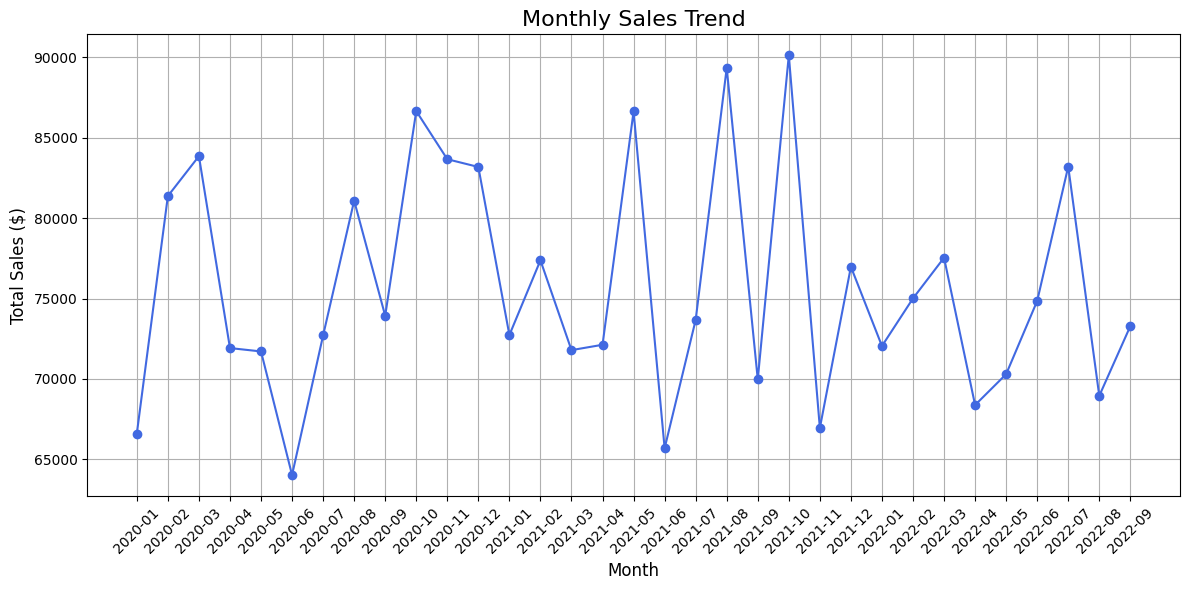

<Figure size 1200x600 with 0 Axes>

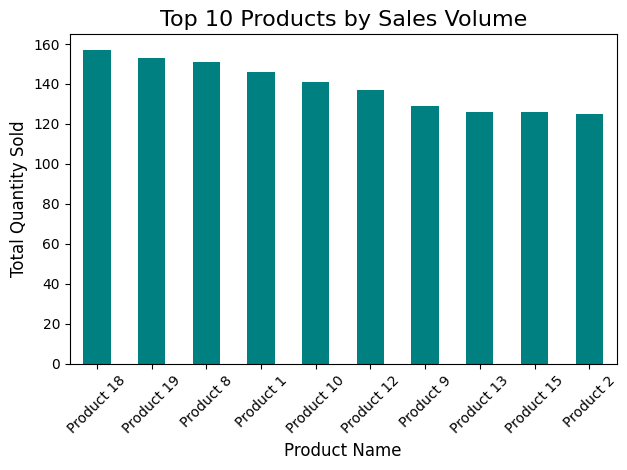

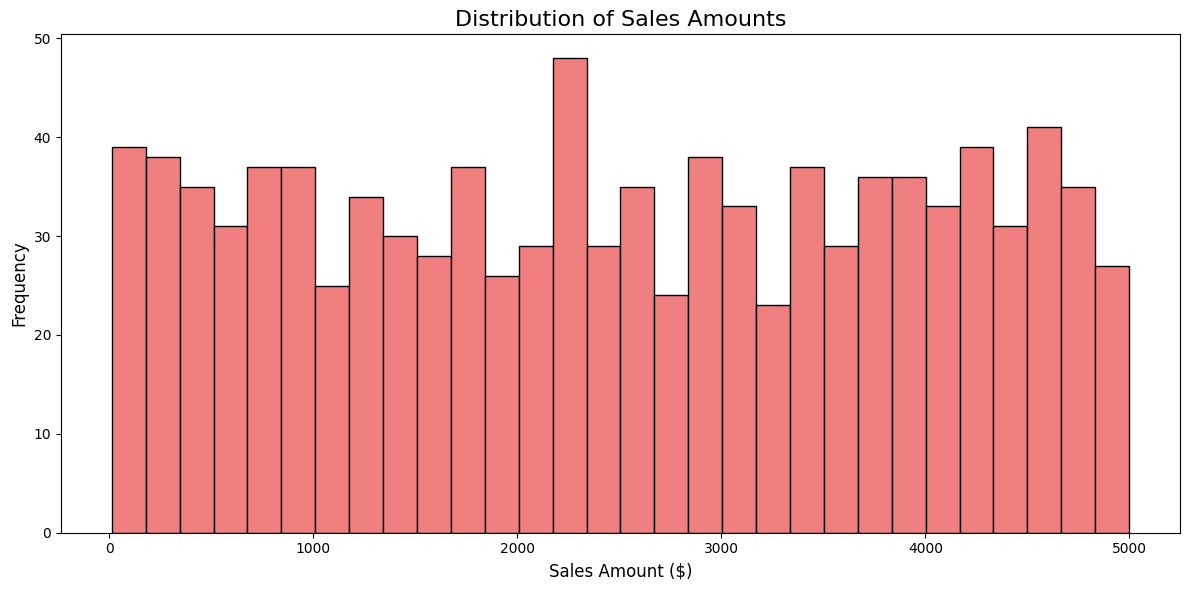

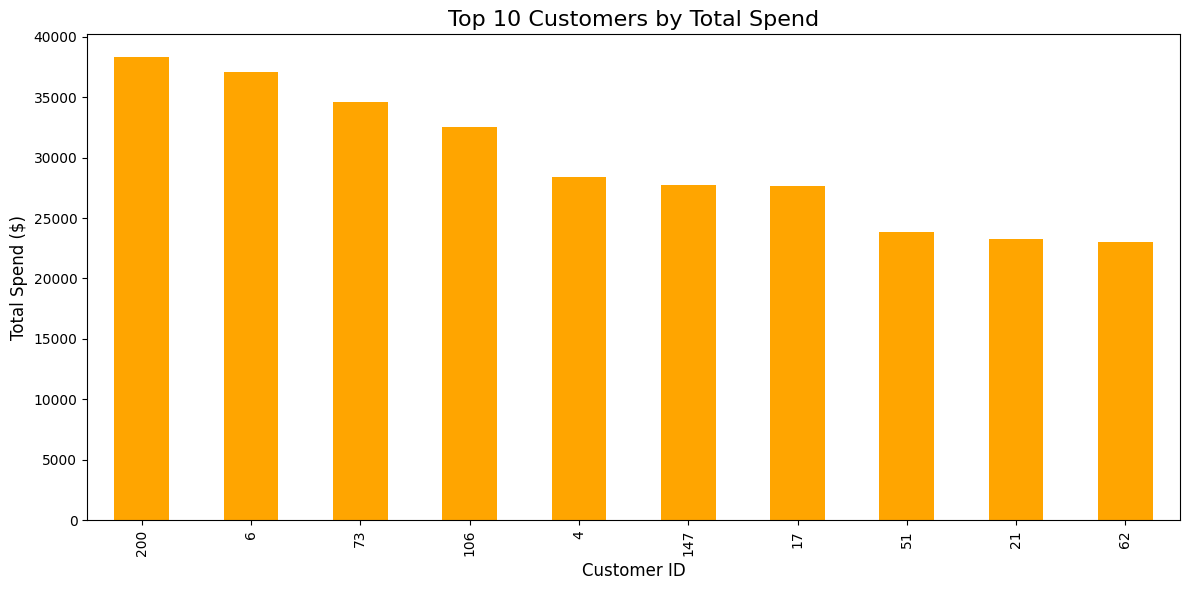

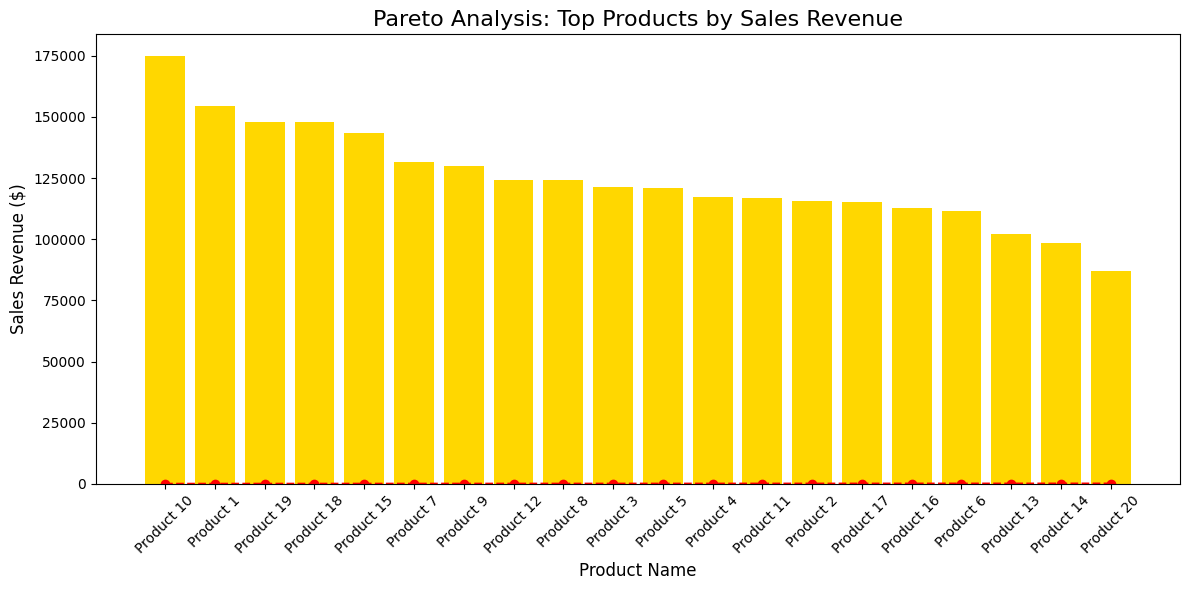

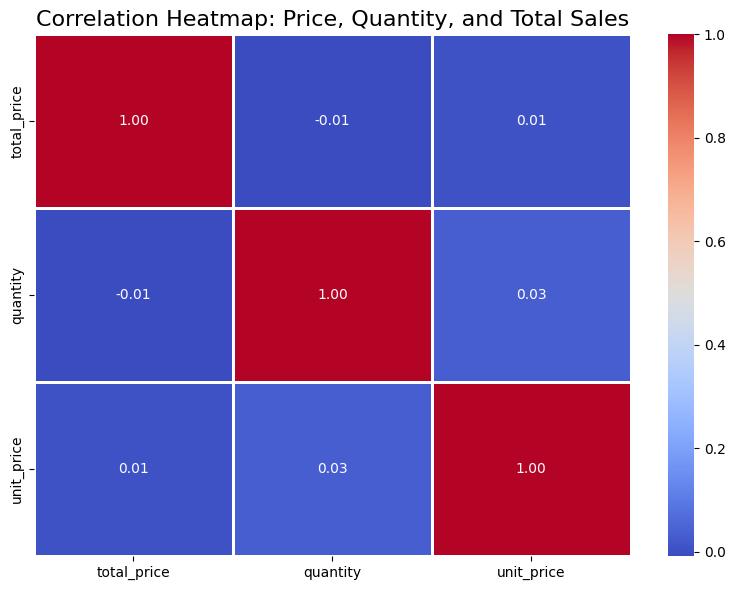

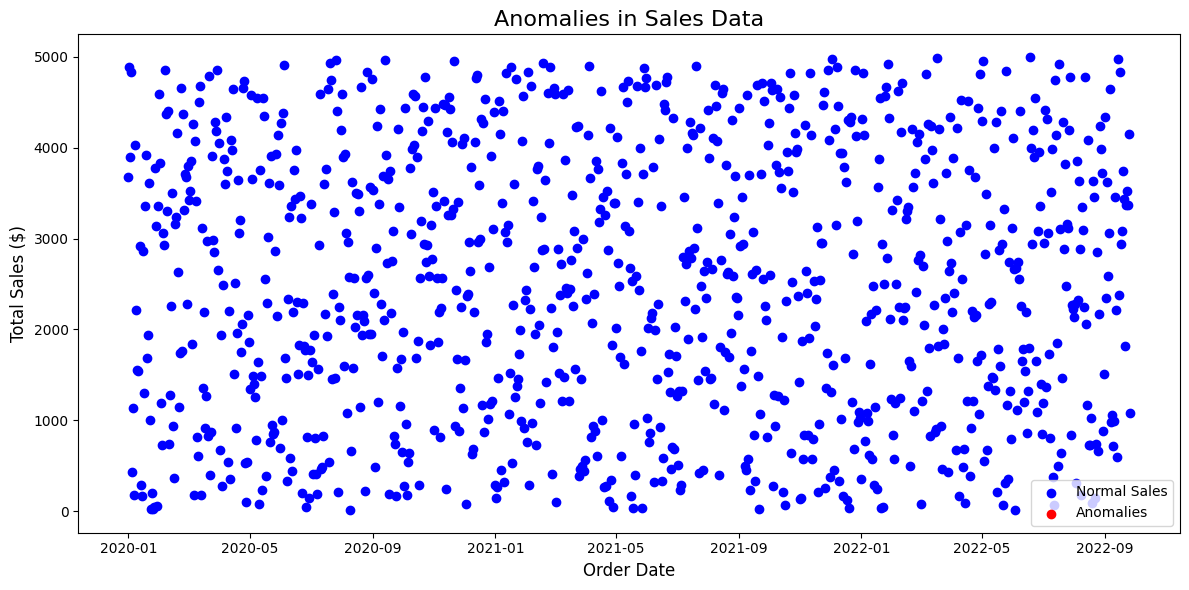

<Figure size 1200x800 with 0 Axes>

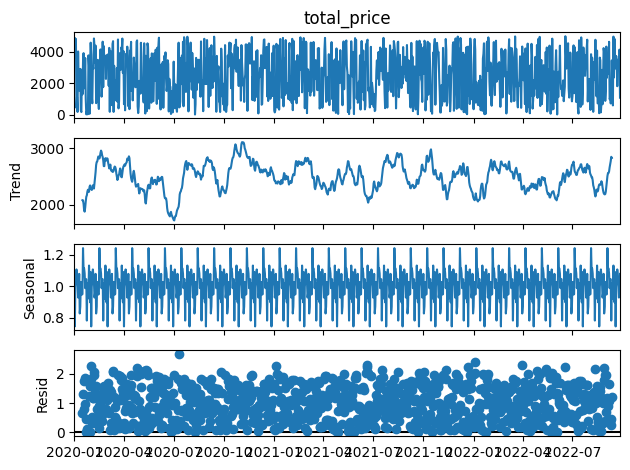

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy.stats import zscore

# Improved prompt structure for high-quality visualizations
def generate_improved_visualizations(df, products_df, model="llama-3.3-70b-versatile"):
    visualizations = []

    # Merge the dataset with product names to use names in the visualizations
    df = df.merge(products_df[['product_id', 'name']], on='product_id', how='left')

    # Visualizations focusing on business insights and trends

    # Sales over time: Using a time-series analysis to visualize monthly sales trend
    if 'order_date' in df.columns and 'total_price' in df.columns:
        # Aggregate sales by month
        df['order_date'] = pd.to_datetime(df['order_date'])
        df['month'] = df['order_date'].dt.to_period('M')
        monthly_sales = df.groupby('month')['total_price'].sum().reset_index()

        fig = plt.figure(figsize=(12, 6))
        plt.plot(monthly_sales['month'].astype(str), monthly_sales['total_price'], marker='o', color='royalblue')
        plt.title('Monthly Sales Trend', fontsize=16)
        plt.xlabel('Month', fontsize=12)
        plt.ylabel('Total Sales ($)', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        visualizations.append(fig)

    # Top 10 products by sales volume: Using a bar chart
    if 'name' in df.columns and 'quantity' in df.columns:
        top_products = df.groupby('name').agg({'quantity': 'sum'}).sort_values('quantity', ascending=False).head(10)
        
        fig = plt.figure(figsize=(12, 6))
        top_products.plot(kind='bar', legend=False, color='teal')
        plt.title('Top 10 Products by Sales Volume', fontsize=16)
        plt.xlabel('Product Name', fontsize=12)
        plt.ylabel('Total Quantity Sold', fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        visualizations.append(fig)

    # Sales distribution: Using a histogram to visualize the spread of sales
    if 'total_price' in df.columns:
        fig = plt.figure(figsize=(12, 6))
        plt.hist(df['total_price'], bins=30, color='lightcoral', edgecolor='black')
        plt.title('Distribution of Sales Amounts', fontsize=16)
        plt.xlabel('Sales Amount ($)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.tight_layout()
        visualizations.append(fig)

    # Customer spend: Top 10 customers with the highest total spend
    if 'customer_id' in df.columns and 'total_price' in df.columns:
        top_customers = df.groupby('customer_id')['total_price'].sum().sort_values(ascending=False).head(10)
        
        fig = plt.figure(figsize=(12, 6))
        top_customers.plot(kind='bar', color='orange', legend=False)
        plt.title('Top 10 Customers by Total Spend', fontsize=16)
        plt.xlabel('Customer ID', fontsize=12)
        plt.ylabel('Total Spend ($)', fontsize=12)
        plt.tight_layout()
        visualizations.append(fig)

    # Pareto chart for sales concentration: Highlighting the top products that generate most of the revenue
    if 'name' in df.columns and 'total_price' in df.columns:
        product_sales = df.groupby('name').agg({'total_price': 'sum'}).sort_values('total_price', ascending=False)
        product_sales['cumulative_percentage'] = product_sales['total_price'].cumsum() / product_sales['total_price'].sum() * 100
        fig = plt.figure(figsize=(12, 6))
        plt.bar(product_sales.index, product_sales['total_price'], color='gold')
        plt.plot(product_sales.index, product_sales['cumulative_percentage'], color='red', marker='o', linestyle='--')
        plt.title('Pareto Analysis: Top Products by Sales Revenue', fontsize=16)
        plt.xlabel('Product Name', fontsize=12)
        plt.ylabel('Sales Revenue ($)', fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        visualizations.append(fig)

    # Heatmap: Correlation between different variables
    if all(col in df.columns for col in ['total_price', 'quantity', 'unit_price']):
        corr_matrix = df[['total_price', 'quantity', 'unit_price']].corr()
        fig = plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, cbar=True)
        plt.title('Correlation Heatmap: Price, Quantity, and Total Sales', fontsize=16)
        plt.tight_layout()
        visualizations.append(fig)

    # Z-Score anomaly detection: Detecting outliers based on sales amount
    if 'total_price' in df.columns:
        df['z_score'] = zscore(df['total_price'])
        anomalies = df[df['z_score'].abs() > 3]
        fig = plt.figure(figsize=(12, 6))
        plt.scatter(df['order_date'], df['total_price'], color='blue', label='Normal Sales')
        plt.scatter(anomalies['order_date'], anomalies['total_price'], color='red', label='Anomalies')
        plt.title('Anomalies in Sales Data', fontsize=16)
        plt.xlabel('Order Date', fontsize=12)
        plt.ylabel('Total Sales ($)', fontsize=12)
        plt.legend()
        plt.tight_layout()
        visualizations.append(fig)

    # Time series decomposition: To break down sales into trend, seasonal, and residuals
    from statsmodels.tsa.seasonal import seasonal_decompose
    if 'order_date' in df.columns and 'total_price' in df.columns:
        df['order_date'] = pd.to_datetime(df['order_date'])
        df.set_index('order_date', inplace=True)
        decomposition = seasonal_decompose(df['total_price'], model='multiplicative', period=30)
        fig = plt.figure(figsize=(12, 8))
        decomposition.plot()
        plt.tight_layout()
        visualizations.append(fig)

    return visualizations


# Example DataFrames
# Main sales data (output_df)
output_df = pd.DataFrame({
    'order_id': np.random.randint(1, 1001, size=1000),
    'customer_id': np.random.randint(1, 201, size=1000),
    'order_date': pd.date_range(start='2020-01-01', periods=1000, freq='D'),
    'product_id': np.random.randint(1, 21, size=1000),
    'quantity': np.random.randint(1, 5, size=1000),
    'unit_price': np.random.uniform(10, 500, size=1000),
    'total_price': np.random.uniform(10, 5000, size=1000)
})

# Product data (products_df)
products_df = pd.DataFrame({
    'product_id': np.arange(1, 21),
    'name': [f'Product {i}' for i in range(1, 21)]
})

# Generate high-quality visualizations
visualizations = generate_improved_visualizations(output_df, products_df)

# Display the generated visualizations
for i, fig in enumerate(visualizations):
    if isinstance(fig, plt.Figure):
        plt.show(fig)
    else:
        fig.show()

